
### 3-7. 프로젝트: 멋진 작사가 만들기





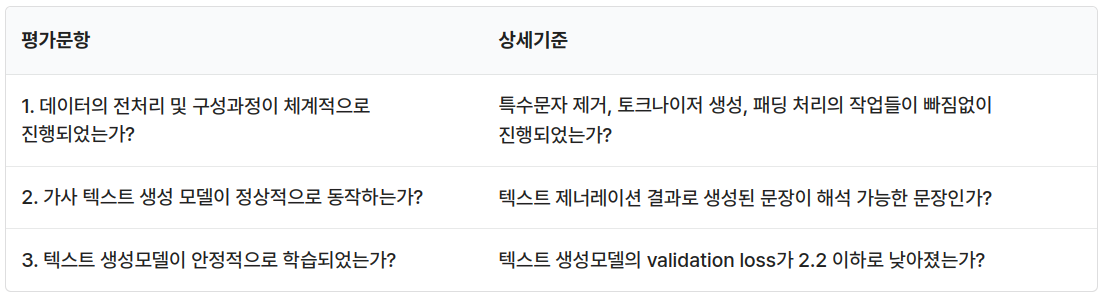

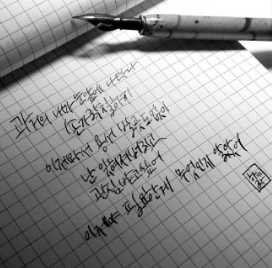

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
import tensorflow

print(tensorflow.__version__)

2.6.0


### Step 1. 데이터 다운로드


- 이미 실습(1)데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있다.



### Step 2. 데이터 읽어오기


- glob 모듈은 파일을 읽어오기 용이. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [2]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']


### Step 3. 데이터 정제, 전처리


- 배운 테크닉들중 preprocess_sentence() 함수로 문장 생성에 적합한 모양새로 데이터를 정제!
  추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거. 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 
  학습 데이터에서 제외.
  
  
  



In [3]:
for idx, sentence in enumerate(raw_corpus):# enumerate() 함수로 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뛴다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜀.

    if idx > 9: break   # 일단 문장 10개만 확인.
        
    print(sentence)

Busted flat in Baton Rouge, waitin' for a train
And I's feelin' near as faded as my jeans
Bobby thumbed a diesel down, just before it rained
It rode us all the way to New Orleans I pulled my harpoon out of my dirty red bandanna
I was playin' soft while Bobby sang the blues, yeah
Windshield wipers slappin' time, I was holdin' Bobby's hand in mine
We sang every song that driver knew Freedom's just another word for nothin' left to lose
Nothin', don't mean nothin' hon' if it ain't free, no no
And, feelin' good was easy, Lord, when he sang the blues
You know, feelin' good was good enough for me


In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 바꾸고, 양쪽 공백을 지움
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꿈.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈.
    sentence = sentence.strip() # 다시 양쪽 공백을 지움, Q 소문자로 바꾸고, 양쪽 공백을 지웠는데 특수문자 양쪽에 공백을 넣은거 지움?
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작에는 <start>, 끝에는 <end>를 추가
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [5]:

corpus = [] # 정제된 문장을 여기에 모음.

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장.
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개 확인.
corpus[:10]

['<start> busted flat in baton rouge , waitin for a train <end>',
 '<start> and i s feelin near as faded as my jeans <end>',
 '<start> bobby thumbed a diesel down , just before it rained <end>',
 '<start> it rode us all the way to new orleans i pulled my harpoon out of my dirty red bandanna <end>',
 '<start> i was playin soft while bobby sang the blues , yeah <end>',
 '<start> windshield wipers slappin time , i was holdin bobby s hand in mine <end>',
 '<start> we sang every song that driver knew freedom s just another word for nothin left to lose <end>',
 '<start> nothin , don t mean nothin hon if it ain t free , no no <end>',
 '<start> and , feelin good was easy , lord , when he sang the blues <end>',
 '<start> you know , feelin good was good enough for me <end>']

### Step 4. 평가 데이터셋 분리

- 훈련 데이터와 평가 데이터를 분리!



- tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리. 
  단어장의 크기는 12,000 이상으로 설정! 총 데이터의 20% 를 평가 데이터셋으로 사용.
  
  
- 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용. 

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용.
def tokenize(corpus):  
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',  
        oov_token="<unk>"  # 12,000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
        )
    
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤.
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춤.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer 
 
tensor, tokenizer = tokenize(corpus)

[[   2 3604 1691 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2  804 7655 ...    0    0    0]
 ...
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f7684152af0>


In [7]:
for idx in tokenizer.index_word: # 단어 10개 확인
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


-  tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성.



-  마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다. Q 뭘보고 아나 ?
    
    

-  [:,:-1]로 자르는 건 세로방향으로 끝까지 가져오고,[ :-1]은 가로방향으로 처음부터 -1번째 인덱스 직전까지.   

In [8]:

src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 3604 1691   14 7050 3995    4 1100   28    9  681    3    0    0
    0    0    0    0    0]
[3604 1691   14 7050 3995    4 1100   28    9  681    3    0    0    0
    0    0    0    0    0]


In [9]:
BUFFER_SIZE = len(src_input)# BUFFER_SIZE : 샘플의 단위
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset
 

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

### Step 5. 인공지능 만들기


- 모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계!



- 잘 설계한 모델을 학습하려면, model.fit() 함수를 사용. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 
  가장 기본적인 인자로는 데이터셋과 epochs. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이.

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x) # Q 추상적 특징, X), )은 왜 복붙안됨?
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [11]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법.

for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-5.9405495e-05,  1.5256630e-04, -2.2067659e-04, ...,
          9.7600867e-05,  2.1455990e-04, -2.0959141e-04],
        [-5.4164586e-04,  3.8139403e-04, -4.3357897e-04, ...,
          8.6625914e-05,  7.5035139e-05, -3.4566026e-04],
        [-6.5996096e-04,  4.4995022e-04, -3.2554439e-04, ...,
         -1.4538536e-04,  6.3334388e-05, -5.9855933e-04],
        ...,
        [ 2.1431739e-04,  6.5820257e-04,  2.4577000e-03, ...,
         -4.2611096e-04,  9.5151732e-04,  3.1699127e-04],
        [ 3.2206578e-04,  5.9691910e-04,  2.6556093e-03, ...,
         -6.0765480e-04,  9.8862685e-04,  4.4874122e-04],
        [ 4.3345042e-04,  5.3337874e-04,  2.8409052e-03, ...,
         -7.7270885e-04,  1.0000734e-03,  5.6767813e-04]],

       [[-5.9405495e-05,  1.5256630e-04, -2.2067659e-04, ...,
          9.7600867e-05,  2.1455990e-04, -2.0959141e-04],
        [ 2.1088240e-04,  4.1261673e-04, -4.5839697e-04, ...,
          2.5366535e-04, 

In [12]:
model.summary() # 모델의 구조를 확인. Q 파이미터 갯수는 ? https://ltlkodae.tistory.com/14

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6144512   
_________________________________________________________________
lstm (LSTM)                  multiple                  6295552   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________


- embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기. 



- hidden_size 는 LSTM 레이어의 hidden state 의 차원수. 

In [13]:
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True

In [14]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저. 
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용.
)

In [15]:
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

In [ ]:
model.fit(src_input, tgt_input, epochs=10, batch_size=2048, validation_split=0.2)

Epoch 1/10
69/69 [==============================] - 430s 6s/step - loss: 3.6448 - val_loss: 2.8422
Epoch 2/10
69/69 [==============================] - 411s 6s/step - loss: 2.8507 - val_loss: 2.7112
Epoch 3/10
30/69 [============>.................] - ETA: 3:35 - loss: 2.7258

- 하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않음. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도. https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고!






- 문장 생성 함수 정의 

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    
    while True: 
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated 

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

### Reference

- https://www.delftstack.com/ko/howto/python/how-to-read-one-file-line-by-line-to-a-list-in-python/  f.read().splitlines() 의미



- https://rekt77.tistory.com/102 Tensor 정리



- https://nittaku.tistory.com/443 random 모듈 



- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit tf공홈 40% Trains the model for a fixed number of epochs 



- https://modulabs.co.kr/blog/python-strangethings/  70%  def __init__(self, f):




### 결론 및 회고 

-  파라미터 갯수는 뭘 나타내나? -> 파라미터 갯수가 클수록 큰data 인건 확인 됐음.




- 디스코드 질문해결 시간에 알게된것 : [:,:-1]로 자르는 건 세로방향으로 끝까지 가져오고, [:-1]은 가로방향으로 처음부터 -1번째 인덱스 직전까지




- Step 4에서 end가 아니라 <pad>일 가능성이 높다. Q 뭘보고 아나 ? -> 노드에서 재확인 ;텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은것. 사전에는  없지만 0은 바로 패딩 문자 <pad>가 될 것
    
    

-Learning rate 는 설정하거나 없애도 결과는 차이가 없었다   
    
    
    
- 데이터 정제, 전처리 과정을 따로 정리했음에도 한눈에 들어오질 않는다.
    
    

- 코드들이 어려운게 많아 코드 파악이 안된게 많았다. 
    
    
    
- 1에픽 8분이나 걸려 에폭 30에서 10으로 줄였으나 제출시한까지 학습을 완료시키지 못했다.    
    
    
    
 
#### [해결 못한 의문점들 ]
 

-hidden_size = 2048, 에폭 20에서 Validation loss가 2.2이하로 안떨어져 hidden_size = 4096으로 대폭 늘렸다. 1에폭도 안돌가고 Internal Error 떴음.
 InternalError:    Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]:
 검색해보니 GPU 문제라고 해서 여러차례 컴퓨터 로그아웃 로그인 하고 embedding_size, hidden_size 등을 조절했으나 해결되지않았음. 어떤게 에폭소요시간 에 영향을 주는지 아직도 파악이 안됨.  
